# Building a CNN to detect abnormalities on X-ray images (MURA dataset) 

# *(Tensorflow - GPU)*

## Description of the dataset
MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.


The data is split into categories determined by one of the following types of scans:
   * XR_ELBOW
   * XR_FINGER
   * XR_FOREARM
   * XR_HAND
   * XR_HUMERUS
   * XR_SHOULDER
   * XR_WRIST
    
    
It is further split according to the patients' ID and then the specific study performed on said patient.
Each study can contain one or more images of the X-ray scan, which are lebaled either as positive or negative, depending on the existence of an abnormality in the musculoskeletal region.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.python.client import device_lib

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import roc_curve, auc

import cv2
import matplotlib.pyplot as plt

import time

import numpy as np
import pandas as pd

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8831853860458143597,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3069915956
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4997022252972640950
 physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

## Constants and Settings

In [3]:
# files
TRAIN_PATHS = 'MURA-v1.1/train_image_paths.csv'
TRAIN_LABELS = 'MURA-v1.1/train_labeled_studies.csv'
VALID_PATHS = 'MURA-v1.1/valid_image_paths.csv'
VALID_LABELS = 'MURA-v1.1/valid_labeled_studies.csv'

RAND_SEED = 111
SAVE_MODEL = True # constant to stop accidentally loading images again
SAVE_DN169 = True # constant to stop accidentally re-training model

FILTERS = ["ALL", # all images
           "ONE_PER_STUDY", # only one image (first one) per study
           "XR_ELBOW", # only images of specified body part 
           "XR_FINGER", 
           "XR_FOREARM",
           "XR_HAND", 
           "XR_HUMERUS",
           "XR_SHOULDER",
           "XR_WRIST"]

# ------------------------------------------------------------------------------------------------------------------------#
np.random.seed(RAND_SEED)
tf.random.set_random_seed(RAND_SEED)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

## Data preprocessing

In [4]:
def filter_data(filter_type, train_paths, train_labels, valid_paths, valid_labels):
    """
    Selects only a specified subset of data for training.
    
    filter_type : str
        constant which defines the subset (see section Constants and Settings above)
    trian_paths, train_labels, valid_paths, valid_labels : pandas.DataFrame
        dataframes containing paths to all sets of data and its labels
    """
    if filter_type == "ALL":
        return train_paths, train_labels, valid_paths, valid_labels
    
    elif filter_type == "ONE_PER_STUDY":
        filt_train_paths = train_paths.loc[train_paths.path.str.contains('.*image1.png')]
        filt_valid_paths = valid_paths.loc[valid_paths.path.str.contains('.*image1.png')]
        return filt_train_paths, train_labels, filt_valid_paths, valid_labels
    
    else:
        filt_train_paths = train_paths.loc[train_paths.path.str.contains(filter_type)]
        filt_valid_paths = valid_paths.loc[valid_paths.path.str.contains(filter_type)]
        filt_train_labels = train_labels.loc[train_labels.study_path.str.contains(filter_type)]
        filt_valid_labels = valid_labels.loc[valid_labels.study_path.str.contains(filter_type)]
        return filt_train_paths, filt_train_labels, filt_valid_paths, filt_valid_labels

def load_data(train_paths, valid_paths, verbose):
    """
    Takes paths to images in training and validation set and uses them to load actual image data into NumPy arrays.
    
    trian_paths, valid_paths : pandas.DataFrame
        dataframes containing paths to all sets of data
    verbose : bool
        if True, function prints progress of loading
    """
    # load training set images
    train_images = []
    if verbose:
        print(f'Loading training images...')
        cnt, i, j = len(train_paths), 1, 0
        
    for index, row in train_paths.iterrows():
        if verbose and j >= i * (cnt // 10):
            print(f' - {i * 10}%', end='')
            i += 1
        train_images.append(cv2.imread(row.path))
        j += 1
    
    # load validation set images
    valid_images = []
    if verbose:
        print(f'\nLoading validation images...')
        cnt, i, j = len(valid_paths), 1, 0
        
    for index, row in valid_paths.iterrows():
        if verbose and j >= i * (cnt // 10):
            print(f' - {i * 10}%', end='')
            i += 1
        valid_images.append(cv2.imread(row.path))
        j += 1

    return train_images, valid_images


def show_sample_grid(images):
    """
    Prints a 5x5 grid with examples of given images.
    
    images : NumPy.ndarray
        contains image data of a certain dataset from which we wish to display a few examples
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()
        

def prep_data(data_paths, input_size, filter_type, show_sample=False, verbose=False):
    """
    Function takes in paths to data and outputs training and validation sets ready for model training.
    
    data_paths : list
        contains two elements, where the first is a list containing paths to training data and labels
        and the second contains paths to validation data and labels
    input_size : tuple
        (width, height) that the images will be resized to
    show_sample : bool
        if True, function prints a grid preview of several images from the training set
    """
    
    # read csv files into dataframes
    train_paths_df = pd.read_csv(data_paths[0][0], header=None, names=['path'])
    train_labels_df = pd.read_csv(data_paths[0][1], header=None, names=['study_path', 'abnormal'])
    valid_paths_df = pd.read_csv(data_paths[1][0], header=None, names=['path'])
    valid_labels_df = pd.read_csv(data_paths[1][1], header=None, names=['study_path', 'abnormal'])
    
    # filter data if only a subset is to be considered
    train_paths_df, train_labels_df, valid_paths_df, valid_labels_df = filter_data(
        filter_type, train_paths_df, train_labels_df, valid_paths_df, valid_labels_df)
    
    # load images
    train_images, valid_images = load_data(train_paths_df, valid_paths_df, verbose)
    
    # load labels for images
    if verbose:
        print('\nLoading labels...')
    train_labels, valid_labels = np.array(train_labels_df.abnormal.tolist()), np.array(valid_labels_df.abnormal.tolist())

    # resize images to given input size
    if verbose:
        print('Resizing images...')
    for i in range(len(train_images)):
        train_images[i] = cv2.resize(train_images[i], input_size)
    for i in range(len(valid_images)):
        valid_images[i] = cv2.resize(valid_images[i], input_size)
        
    train_images = np.array(train_images)
    valid_images = np.array(valid_images)
    
    # TODO preprocessing here
    
    if show_sample:
        show_sample_grid(train_images)
        
    return train_images, train_labels, valid_images, valid_labels
    

In order to simplify the problem and the CNN architecture for now, I have reduced the number of images per study to just one by using the *ONE_PER_STUDY* filtering option



Based on the MURA baseline and the paper published along with it, I will resize all images to 320 x 320 pixels in order to have consisent inputs for the CNN



Loading training images...
 - 10% - 20% - 30% - 40% - 50% - 60% - 70% - 80% - 90% - 100%
Loading validation images...
 - 10% - 20% - 30% - 40% - 50% - 60% - 70% - 80% - 90% - 100%
Loading labels...
Resizing images...


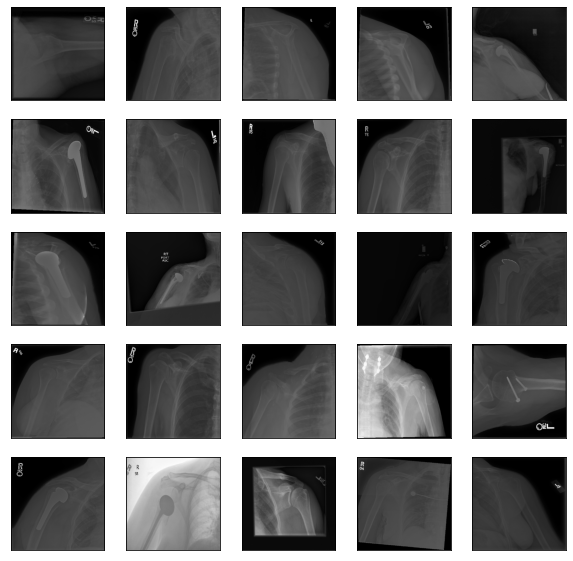

Finished after 96.76 seconds


In [5]:
start = time.time()

train_images, train_labels, valid_images, valid_labels = prep_data(
    [[TRAIN_PATHS, TRAIN_LABELS], [VALID_PATHS, VALID_LABELS]], (320, 320), FILTERS[1], show_sample=True, verbose=True)

print(f'Finished after {(time.time() - start):.2f} seconds')

In [6]:
# check train and validation set sizes
print(train_images.shape)
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)

(13457, 320, 320, 3)
(13457,)
(1199, 320, 320, 3)
(1199,)


## Build model

Setup convolutional base with 3 x 3 feature filters (number of filters increases as input sizes get smaller)

MaxPooling 2 x 2 filter to reduce feature sizes

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(320, 320, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Classify image based on extracted features by first flattening the feature vector, then fully connecting to dense layer of 64 neurons and finally connecting those to the output neuron

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 320, 320, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 158, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)        3

## Train model

In [10]:
start = time.time()

model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])
    
history = model.fit(x=train_images, y=train_labels, epochs=10, validation_data=(valid_images, valid_labels), verbose=2)

print(f'Finished after {(time.time() - start):.2f} seconds')

Train on 13457 samples, validate on 1199 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
13457/13457 - 93s - loss: 5.9375 - acc: 0.6151 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 2/10
13457/13457 - 88s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 3/10
13457/13457 - 90s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 4/10
13457/13457 - 90s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 5/10
13457/13457 - 90s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 6/10
13457/13457 - 91s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 7/10
13457/13457 - 92s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 8/10
13457/13457 - 89s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Epoch 9/10
13457/13457 - 91s - loss: 5.9341 - acc: 0.6153 - val_loss: 6.9213 - val_acc: 0.5513
Ep

## Test model

In [11]:
preds = model.predict(valid_images, verbose=1)

1199/1199 [==============================] - 4s 3ms/sample


In [12]:
valid_loss, valid_acc = model.evaluate(valid_images, valid_labels, verbose=1)

1199/1199 [==============================] - 4s 3ms/sample - loss: 6.9213 - acc: 0.5513


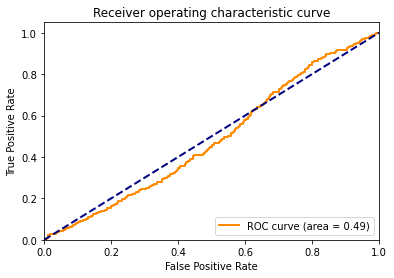

In [13]:
fpr, tpr, _ = roc_curve(valid_labels, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
if SAVE_MODEL:
    model.save('mura_basic_model.h5')

# -----------------------------------------------------------------------------------------------------------

# Preloading the DenseNet169 architecture and testing it on MURA

The Stanford baseline uses the DenseNet169 architecture as the convolutional base of its model, so I will attempt to load it and use it as well

## Load convolutional base

In [15]:
base_model = tf.keras.applications.DenseNet169(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

base_model.trainable = False # freeze base

## Create classifier and merge models

Picks global averages from the pool of features

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Output layer

In [17]:
prediction_layer = tf.keras.layers.Dense(1)

In [18]:
densenet_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [19]:
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, None, None, 1664)  12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


## Train model

In [20]:
base_learning_rate = 0.0001

densenet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

See how evaluating the model goes before even training it

In [21]:
initial_epochs = 3

loss0, accuracy0 = densenet_model.evaluate(valid_images, valid_labels)

1199/1199 [==============================] - 32s 27ms/sample - loss: 0.9294 - acc: 0.5221


In [22]:
densenet_history = densenet_model.fit(x=train_images, y=train_labels,
                    epochs=initial_epochs,
                    validation_data=(valid_images, valid_labels),
                    verbose=2)

Train on 13457 samples, validate on 1199 samples
Epoch 1/3
13457/13457 - 284s - loss: 0.6508 - acc: 0.6178 - val_loss: 0.8257 - val_acc: 0.5571
Epoch 2/3
13457/13457 - 260s - loss: 0.6142 - acc: 0.6307 - val_loss: 0.8898 - val_acc: 0.5563
Epoch 3/3
13457/13457 - 264s - loss: 0.5923 - acc: 0.6488 - val_loss: 1.0025 - val_acc: 0.5546


## Test model

In [23]:
preds_dn = densenet_model.predict(valid_images, verbose=1)

1199/1199 [==============================] - 22s 19ms/sample


In [24]:
valid_loss, valid_acc = densenet_model.evaluate(valid_images, valid_labels, verbose=1)

1199/1199 [==============================] - 19s 16ms/sample - loss: 1.0025 - acc: 0.5546


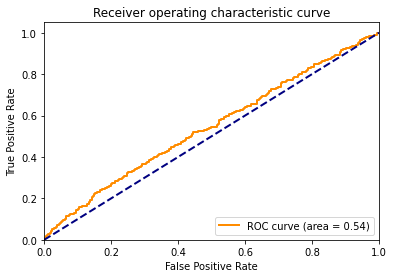

In [25]:
fpr, tpr, _ = roc_curve(valid_labels, preds_dn)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
if SAVE_DN169:
    densenet_model.save('mura_densenet169.h5')